In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
import csv, pickle
from tqdm.notebook import tqdm as tqdm
from functools import partial
import multiprocessing as mp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA

import numpy as np
import torch
import torch_geometric

In [3]:
import SORBET
import SORBET.data_handling as data_handling
import SORBET.learning as learning
from SORBET.learning.dataset import TorchOmicsDataset

# Load IMC Cohorts Data

In [ ]:
excluded_markers = set(["Cell_131Xe_131Xe", "Cell_132Xe_132Xe", "Cell_200Hg_200Hg", "Cell_190BCKG_190BCKG"])
def load_c_patient(fpath, graph_label, excluded=excluded_markers):
    
    cell_list = list()
    edge_list = set()
    marker_list = list()
    
    make_edge = lambda i,j: tuple(sorted([i,j]))
    
    with open(fpath, 'r') as ifile:
        reader = csv.reader(ifile, delimiter=',')
        
        header = next(reader)
        neighbors_start_index = header.index('Number_Neighbors') + 1
        
        markers = header[2:35]
        marker_filt_list = [True if mi not in excluded else False for mi in markers]
        
        for row in reader:
            cell_id = int(row[1])
            cell_list.append(cell_id)
            
            cell_markers = list(map(float, row[2:35]))
            cell_markers = [float(mv) for mv, mfilt in zip(row[2:35], marker_filt_list) if mfilt]
            marker_list.append(cell_markers)
            
            neighbors = list(filter(lambda cid: cid != 0, (int(i) for i in row[neighbors_start_index:])))
            edge_list |= set(map(lambda nid: make_edge(nid, cell_id), neighbors))

    markers = [mi for mi, mfilt in zip(markers, marker_filt_list) if mfilt]
    return data_handling.OmicsGraph(cell_list, edge_list, np.array(marker_list), markers, graph_label)

In [ ]:
for cnum in [1,2]:
    graph_mapping = dict()

    labels = list()

    output_dirpath = f"data/c{cnum}/graphs_py/complete/"
    if not os.path.exists(output_dirpath):
        os.makedirs(output_dirpath)

    responders_dirpath = f"data/c{cnum}/raw_data/DCB/"
    nonresponders_dirpath = f"data/c{cnum}/raw_data/NDB/"

    for ifile in os.listdir(responders_dirpath):
        gid = os.path.splitext(ifile)[0]
        data_graph = load_c_patient(os.path.join(responders_dirpath, ifile), 1)
        
        output_file = os.path.join(output_dirpath, f'{gid}.p')
        data_handling.dump_omicsgraph(data_graph, output_file)
        
        labels.append((gid, 1, "Responder", output_file))
        

    for ifile in os.listdir(nonresponders_dirpath):
        gid = os.path.splitext(ifile)[0]
        data_graph = load_c_patient(os.path.join(nonresponders_dirpath, ifile), 0)
        
        output_file = os.path.join(output_dirpath, f'{gid}.p')
        data_handling.dump_omicsgraph(data_graph, output_file)
        
        labels.append((gid, 0, "Responder", output_file))
        
        
    labels_fpath = f"data/c{cnum}/labels.csv"
    with open(labels_fpath, 'w+') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow(["Graph ID", "Label", "Label Meaning", "Complete Graph"])
        writer.writerows(labels)
        
    print(len(labels))

In [ ]:
for cnum in [1,2]:    
    complete_graphs_dirpath = f"data/c{cnum}/graphs_py/complete/"
    normalized_graphs_dirpath = f"data/c{cnum}/graphs_py/normalized/"
    lognormalized_graphs_dirpath = f"data/c{cnum}/graphs_py/lognormalized/"
    znormalized_graphs_dirpath = f"data/c{cnum}/graphs_py/znormalized/"
    rangenormalized_graphs_dirpath = f"data/c{cnum}/graphs_py/rangenormalized/"

    for d in [normalized_graphs_dirpath, lognormalized_graphs_dirpath, znormalized_graphs_dirpath, rangenormalized_graphs_dirpath]:
        if not os.path.exists(d): os.makedirs(d)

    for ifile in os.listdir(complete_graphs_dirpath):
        igraph_fpath = os.path.join(complete_graphs_dirpath, ifile)
        
        omics_graph = data_handling.load_omicsgraph(igraph_fpath)
        data_handling.normalize_graph(omics_graph, "total_count")
        data_handling.dump_omicsgraph(omics_graph, os.path.join(normalized_graphs_dirpath, ifile))
        
        omics_graph = data_handling.load_omicsgraph(igraph_fpath)
        data_handling.normalize_graph(omics_graph, "log_normalize")
        data_handling.dump_omicsgraph(omics_graph, os.path.join(lognormalized_graphs_dirpath, ifile))
    ofiles, log_graphs = list(), list()
    for ifile in os.listdir(lognormalized_graphs_dirpath):
        igraph_fpath = os.path.join(lognormalized_graphs_dirpath, ifile)
        omics_graph = data_handling.load_omicsgraph(igraph_fpath)
        log_graphs.append(omics_graph)

        ofiles.append(os.path.join(znormalized_graphs_dirpath, ifile))

    data_handling.normalize_dataset(log_graphs, "z-normalize")
    for ofile, graph in zip(ofiles, log_graphs):
        data_handling.dump_omicsgraph(graph, ofile)
    ofiles, log_graphs = list(), list()
    for ifile in os.listdir(lognormalized_graphs_dirpath):
        igraph_fpath = os.path.join(lognormalized_graphs_dirpath, ifile)
        omics_graph = data_handling.load_omicsgraph(igraph_fpath)
        log_graphs.append(omics_graph)

        ofiles.append(os.path.join(rangenormalized_graphs_dirpath, ifile))

    data_handling.normalize_dataset(log_graphs, "to-range")
    for ofile, graph in zip(ofiles, log_graphs):
        data_handling.dump_omicsgraph(graph, ofile)

In [ ]:
def create_summaary_embeddings_dataset(input_dirpath, output_dirpath):
    for ifile in os.listdir(input_dirpath):
        igraph_fpath = os.path.join(input_dirpath, ifile)
        omics_graph = data_handling.load_omicsgraph(igraph_fpath)
        markers = omics_graph.markers
        # keep only the name after the last underscore
        markers = [m.split("_")[-1] for m in markers]
        node_data = omics_graph.get_node_data()
        cell_embedding = data_handling.create_summary_embedding(markers, node_data)
        omics_graph.set_node_data(cell_embedding, [f"cell_embedding_{i}" for i in range(cell_embedding.shape[1])])
        data_handling.dump_omicsgraph(omics_graph, os.path.join(output_dirpath, ifile))
        

In [ ]:
for cnum in [1,2]:
    rangenormalized_graphs_dirpath = f"data/c{cnum}/graphs_py/rangenormalized/"
    rangenormalized_summary_graphs_dirpath = f"data/c{cnum}/graphs_py/rangenormalized_summary/"
    if not os.path.exists(rangenormalized_summary_graphs_dirpath): os.makedirs(rangenormalized_summary_graphs_dirpath)
    create_summaary_embeddings_dataset(rangenormalized_graphs_dirpath, rangenormalized_summary_graphs_dirpath)


In [ ]:
def create_cell_sentenecs_dataset(input_dirpath, output_dirpath):
    for ifile in os.listdir(input_dirpath):
        igraph_fpath = os.path.join(input_dirpath, ifile)
        omics_graph = data_handling.load_omicsgraph(igraph_fpath)
        markers = omics_graph.markers
        # keep only the name after the last underscore
        markers = [m.split("_")[-1] for m in markers]
        node_data = omics_graph.get_node_data()
        cell_embedding = data_handling.get_cell_embeddings(node_data, markers)
        omics_graph.set_node_data(cell_embedding, [f"cell_embedding_{i}" for i in range(cell_embedding.shape[1])])
        data_handling.dump_omicsgraph(omics_graph, os.path.join(output_dirpath, ifile))

In [ ]:
for cnum in [1,2]:
    rangenormalized_graphs_dirpath = f"data/c{cnum}/graphs_py/rangenormalized/"
    rangenormalized_cell_setences_dirpath = f"data/c{cnum}/graphs_py/rangenormalized_cell_sentences/"
    if not os.path.exists(rangenormalized_cell_setences_dirpath): os.makedirs(rangenormalized_cell_setences_dirpath)
    create_cell_sentenecs_dataset(rangenormalized_graphs_dirpath, rangenormalized_cell_setences_dirpath)
    

In [ ]:
for cnum in [1,2]:    
    K = 10 # Neighborhood size
    MS = 50 # Minimum size
    anchor_marker = "Cell_148Nd_PANCK" if cnum == 1 else "Cell_148Nd_panCK"

    idirs = [f"data/c{cnum}/graphs_py/rangenormalized/",  f"data/c{cnum}/graphs_py/rangenormalized_summary/", f"data/c{cnum}/graphs_py/rangenormalized_cell_sentences/"]
    odir_names = ["original_subgraphs", "summary_subgraphs", "cell_sentence_subgraphs"]

    for idir, odirn in zip(idirs, odir_names):
        odir = f'data/c{cnum}/{odirn}'
        if not os.path.exists(odir):
            os.makedirs(odir)

        if odirn == "original_subgraphs":
            graphs_for_node_data_dirpath = None
        else:
            graphs_for_node_data_dirpath = idir
        data_handling.create_subgraphs(f"data/c{cnum}/graphs_py/rangenormalized/", odir, "microenvironment",  {"marker": anchor_marker, "k": K, "minimum_size":MS}, graphs_for_node_data_dirpath=graphs_for_node_data_dirpath)
        data_handling.create_torch_subgraphs(odir)

# Learning Phase

In [4]:
def report_and_visualize_results(results, model_type, metadata_files, root_fpath, logdir, tmp_kfold_split, labels_comb, preds_comb, model_name, input_dim):
    config = results.get_best_result(mode="max", metric="auroc").metrics['config']
    params, model_structure = learning.get_model_and_training_specifications(config, model_type, input_dim)
    print(params)
    fig, axes = plt.subplots(1,2,figsize=(10,5), sharey=True)
    auroc_results = []
    for spl_id, (train_ids, val_ids, test_ids) in enumerate(tqdm(tmp_kfold_split)):
        train_ds = learning.TorchOmicsDataset(root_fpath, metadata_files, train_ids)
        val_ds = learning.TorchOmicsDataset(root_fpath, metadata_files, val_ids)
        test_ds = learning.TorchOmicsDataset(root_fpath, metadata_files, test_ids)
        _, (preds, labs), acc, tl, vl = learning.train_model(model_type, model_structure, [train_ds, val_ds, test_ds], print_lvl=0, tensorboard_dir=logdir, **params)
        
        axes[0].plot(list(range(1,len(tl)+1)), [np.mean(a) for a in tl], label=f'Run {spl_id} - Train')
        axes[1].plot([t[0] for t in vl], [t[1] for t in vl], label=f'Run {spl_id} - Val')

        auroc = roc_auc_score(labs, preds)
        print(f'Split {spl_id} AUROC: {auroc:.3f}')
        auroc_results.append(auroc)
        labels_comb.extend(labs)
        preds_comb.extend(preds)

    axes[0].legend(loc='upper right')
    axes[1].legend(loc='upper right')
    plt.show()

    learning.plot_model_calibration(labels_comb, preds_comb); plt.show();
    learning.plot_combined_metrics([["GCN", preds_comb, labels_comb]]); plt.show();
    fig.savefig(f'{model_name}_training.png', dpi=300)
    return params, model_structure


In [5]:
def optimize_hyperparameters(cnum, path_to_data, model_name, input_dim):
    if cnum != 1 and cnum != 2:
        raise ValueError("cnum must be 1 or 2")
    path_to_data = path_to_data.format(cnum=cnum)
    print(path_to_data)
    if not os.path.exists(path_to_data):
        raise ValueError("path_to_data must be a valid path to the data")
    labels_fpath = f"data/c{cnum}/labels.csv"
    root_fpath = os.path.abspath("./")
    metadata_files = learning.make_subgraph_metadata(path_to_data)
    tmp_kfold_split = list(learning.stratified_kfold_split(labels_fpath, 5, include_validation=True))
    labels_comb, preds_comb = list(), list()

    logdir = os.path.abspath(f"runs/c{cnum}/test/{model_name}")

    model = learning.GCNSorbetBase
    hyperparamter_space = {
        # Training Hyperparamters:
        "epochs": [100],
        "learning_rate": [1e-4,9e-4],
        "batch_size": [64],
        "l1_penalty": [1e-4, 1e-2],
        "restarts": [1],
        # Model Structure Hyperparamters:
        "in_linear_channels": [2, 3, 70, 100],
        "conv_channels": [2, 3,  70, 100],
        "embedding_linear_channels": [1, 2,  70, 100],
        "out_linear_channels": [1, 2, 30, 100],
        "dropout": [0],
        "pooling_fn": ["global_max"]
}

    results = learning.hyperparameter_optimization(
        tmp_kfold_split, root_fpath, metadata_files, input_dim, 
        model, hyperparamter_space, set_model = False, num_model_evals=40,
        n_cpus = 48, n_gpus = 8, allow_fractional = 0.5
    )
    return report_and_visualize_results(results, model, metadata_files, root_fpath, logdir, tmp_kfold_split, labels_comb, preds_comb, model_name, input_dim) 

In [6]:
def train_model_on_one_chort_and_test_on_the_other(cnum_to_train_on, path_to_data, model_name, input_dim):
    if cnum_to_train_on != 1 and cnum_to_train_on != 2:
        raise ValueError("cnum must be 1 or 2")
    cnum_to_test_on = 2 if cnum_to_train_on == 1 else 1
    params, model_structure = optimize_hyperparameters(cnum_to_train_on, path_to_data, model_name, input_dim)
    path_to_data_train = path_to_data.format(cnum=cnum_to_train_on)
    path_to_data_test = path_to_data.format(cnum=cnum_to_test_on)
    test_labels_fpath = f"data/c{cnum_to_test_on}/labels.csv"
    train_labels_fpath = f"data/c{cnum_to_train_on}/labels.csv"
    root_fpath = os.path.abspath("./")
    metadata_files_train = learning.make_subgraph_metadata(path_to_data_train)
    metadata_files_test = learning.make_subgraph_metadata(path_to_data_test)
    train_ids = learning.get_all_sample_ids(train_labels_fpath)
    test_ids = learning.get_all_sample_ids(test_labels_fpath)
    # get the whole dataset for training
    train_ds = TorchOmicsDataset(root_fpath, metadata_files_train, train_ids)
    test_ds = TorchOmicsDataset(root_fpath, metadata_files_test, test_ids)
    model = learning.GCNSorbetBase
    _, (preds, labs), acc, tl, vl = learning.train_model(model, model_structure, [train_ds, test_ds], print_lvl=0, tensorboard_dir=None, **params)
    fig, axes = plt.subplots(1,2,figsize=(10,5), sharey=True)
    learning.plot_model_calibration(labs, preds); plt.show();
    learning.plot_combined_metrics([[model_name, preds, labs]]); plt.show();
    fig.savefig(f'{model_name}_test.png', dpi=300)
    
    

(objective pid=1450832) Training on 215 samples, validating on 47 samples.
(objective pid=1450832) /home/shay/SORBET_shay
(objective pid=1450974) Training on 215 samples, validating on 47 samples.
(objective pid=1450974) /home/shay/SORBET_shay
(objective pid=1451104) Training on 215 samples, validating on 47 samples.
(objective pid=1451104) /home/shay/SORBET_shay
(objective pid=1451246) Training on 215 samples, validating on 47 samples.
(objective pid=1451246) /home/shay/SORBET_shay
(objective pid=1451386) Training on 215 samples, validating on 47 samples.
(objective pid=1451386) /home/shay/SORBET_shay
(objective pid=1451516) Training on 215 samples, validating on 47 samples.
(objective pid=1451516) /home/shay/SORBET_shay
(objective pid=1451656) Training on 215 samples, validating on 47 samples.
(objective pid=1451656) /home/shay/SORBET_shay
(objective pid=1451793) Training on 215 samples, validating on 47 samples.
(objective pid=1451793) /home/shay/SORBET_shay
(objective pid=1451933) 

2023-12-18 15:55:17,499	INFO tune.py:1148 -- Total run time: 1222.17 seconds (1222.12 seconds for the tuning loop).


{'epochs': 100, 'learning_rate': 0.00010842114702450468, 'batch_size': 64, 'restarts': 1}


  0%|          | 0/5 [00:00<?, ?it/s]

Split 0 AUROC: 0.998
Split 1 AUROC: 0.729
Split 2 AUROC: 0.834
Split 3 AUROC: 0.759
Split 4 AUROC: 0.495


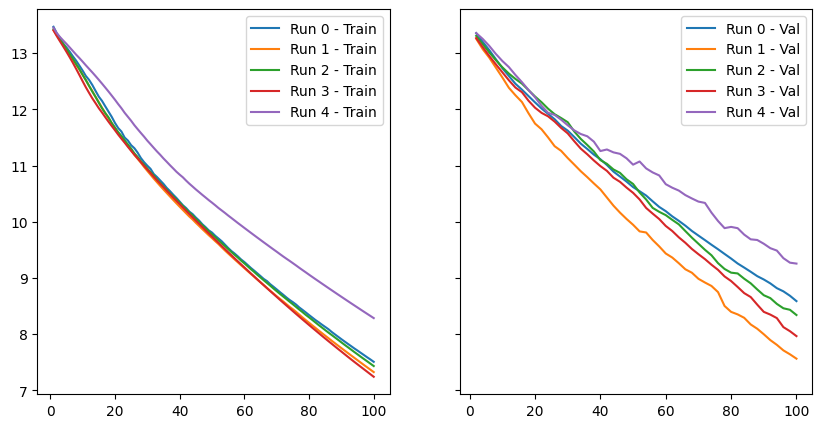

0.0 0.1 180
0.1 0.2 12
0.2 0.30000000000000004 11
0.30000000000000004 0.4 14
0.4 0.5 11
0.5 0.6000000000000001 17
0.6000000000000001 0.7000000000000001 18
0.7000000000000001 0.8 23
0.8 0.9 24
0.9 1.0 65


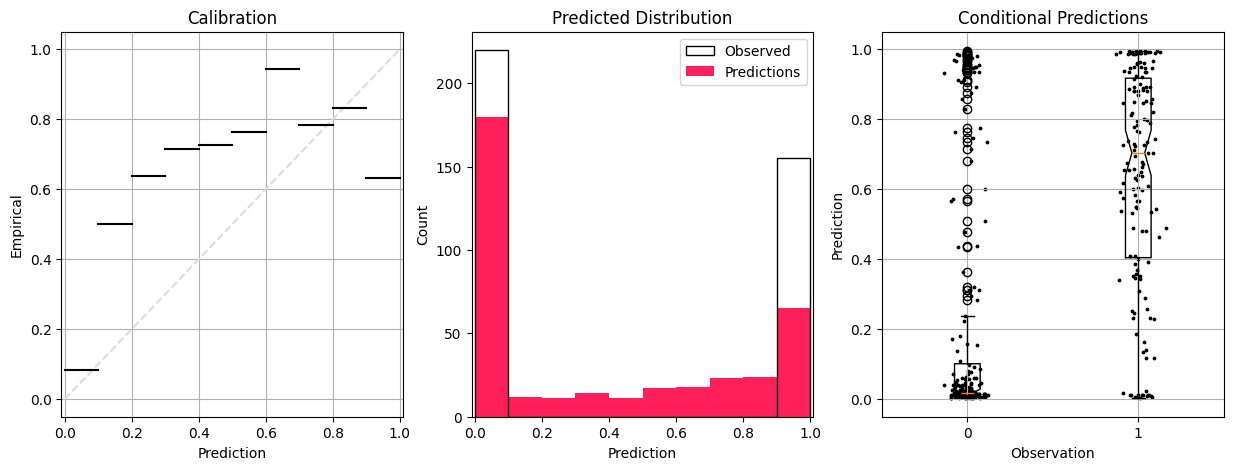

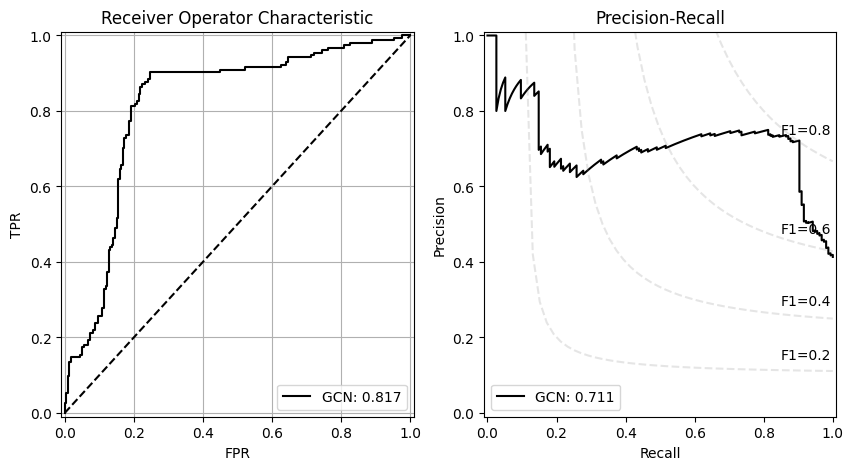

0.0 0.1 116
0.1 0.2 37
0.2 0.30000000000000004 38
0.30000000000000004 0.4 36
0.4 0.5 35
0.5 0.6000000000000001 55
0.6000000000000001 0.7000000000000001 59
0.7000000000000001 0.8 102
0.8 0.9 104
0.9 1.0 144


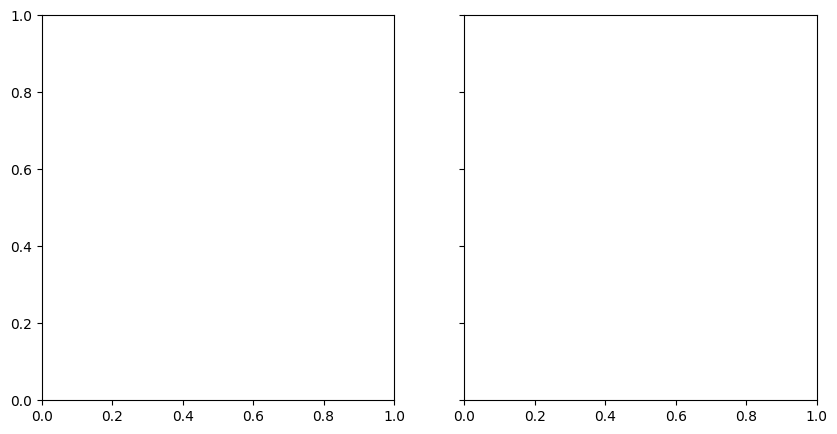

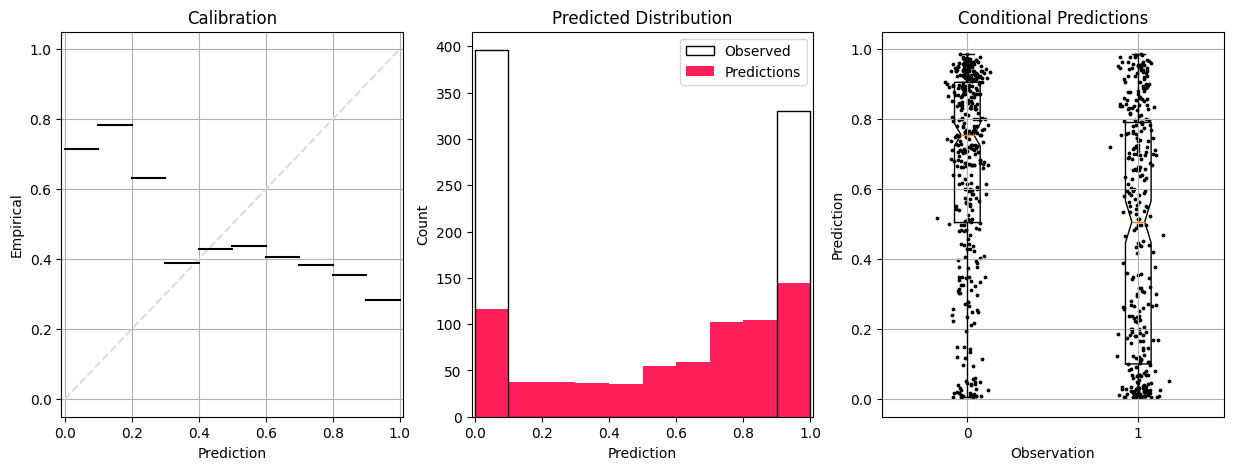

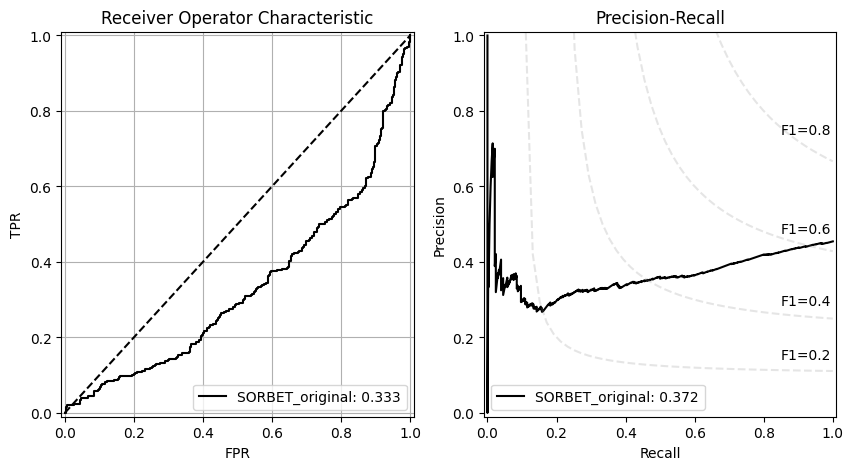

In [7]:
train_model_on_one_chort_and_test_on_the_other(1, "data/c{cnum}/original_subgraphs", "SORBET_original", 29)

(objective pid=1466382) Training on 195 samples, validating on 84 samples.
(objective pid=1466382) /home/shay/SORBET_shay
(objective pid=1466516) Training on 195 samples, validating on 84 samples.
(objective pid=1466516) /home/shay/SORBET_shay
(objective pid=1466660) Training on 195 samples, validating on 84 samples.
(objective pid=1466660) /home/shay/SORBET_shay
(objective pid=1466796) Training on 195 samples, validating on 84 samples.
(objective pid=1466796) /home/shay/SORBET_shay
(objective pid=1466930) Training on 195 samples, validating on 84 samples.
(objective pid=1466930) /home/shay/SORBET_shay
(objective pid=1467063) Training on 195 samples, validating on 84 samples.
(objective pid=1467063) /home/shay/SORBET_shay
(objective pid=1467193) Training on 195 samples, validating on 84 samples.
(objective pid=1467193) /home/shay/SORBET_shay
(objective pid=1467336) Training on 195 samples, validating on 84 samples.
(objective pid=1467336) /home/shay/SORBET_shay
(objective pid=1467473) 

2023-12-18 16:27:02,179	INFO tune.py:1148 -- Total run time: 1617.35 seconds (1617.31 seconds for the tuning loop).


{'epochs': 100, 'learning_rate': 0.00011274637496531561, 'batch_size': 64, 'restarts': 1}


  0%|          | 0/5 [00:00<?, ?it/s]

Split 0 AUROC: 0.660
Split 1 AUROC: 0.351
Split 2 AUROC: 0.985
Split 3 AUROC: 0.713
Split 4 AUROC: 0.970


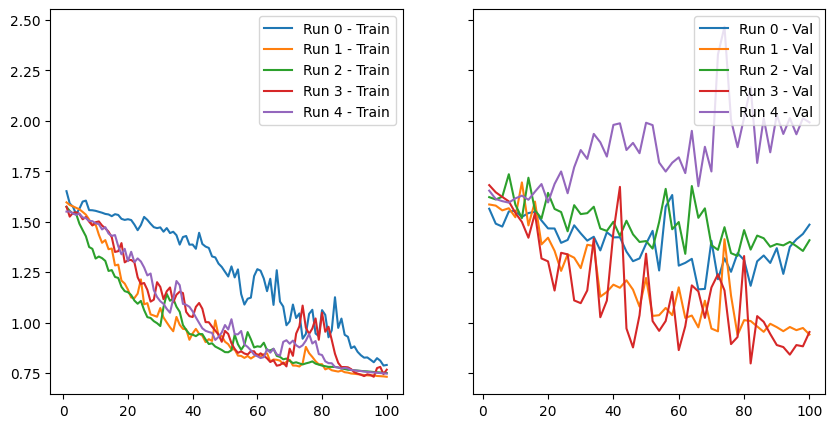

0.0 0.1 166
0.1 0.2 21
0.2 0.30000000000000004 10
0.30000000000000004 0.4 10
0.4 0.5 10
0.5 0.6000000000000001 9
0.6000000000000001 0.7000000000000001 15
0.7000000000000001 0.8 17
0.8 0.9 25
0.9 1.0 92


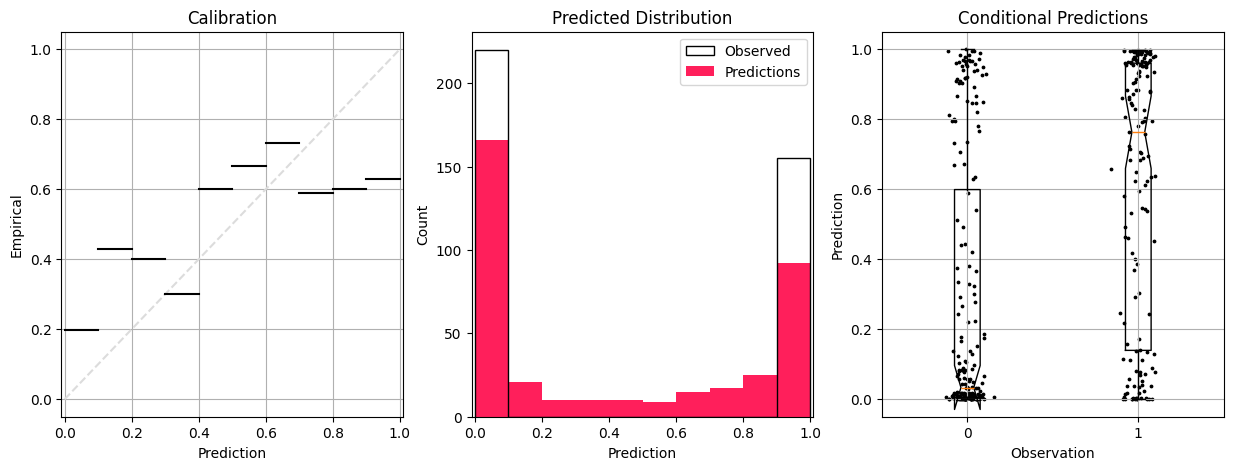

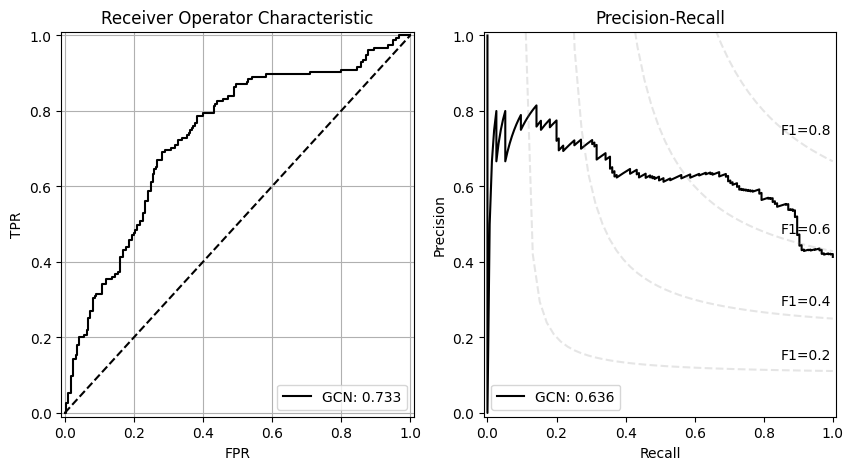

0.0 0.1 462
0.1 0.2 96
0.2 0.30000000000000004 40
0.30000000000000004 0.4 27
0.4 0.5 20
0.5 0.6000000000000001 16
0.6000000000000001 0.7000000000000001 16
0.7000000000000001 0.8 16
0.8 0.9 9
0.9 1.0 24


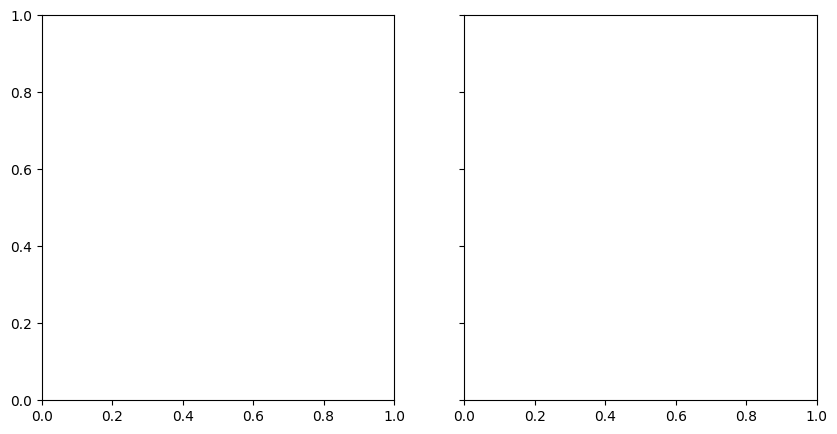

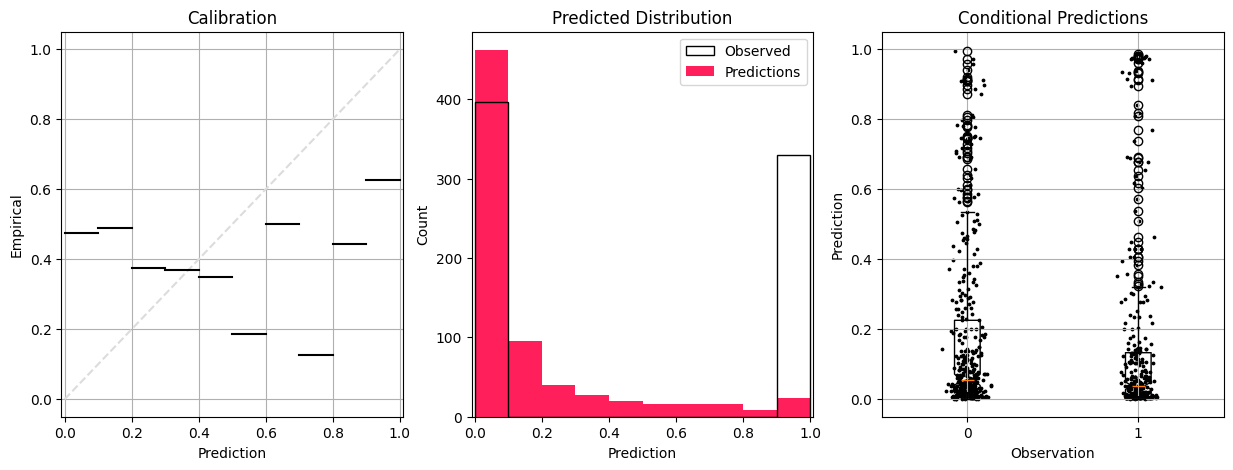

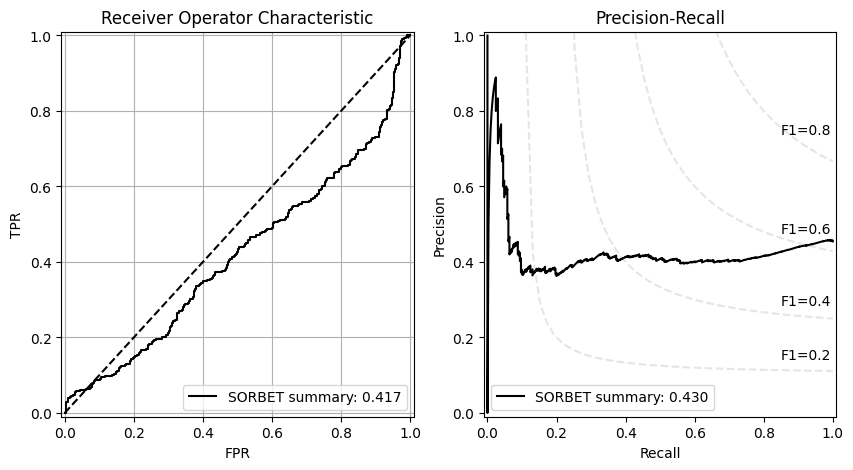

In [8]:
train_model_on_one_chort_and_test_on_the_other(1, "data/c{cnum}/summary_subgraphs", "SORBET summary", 768)

(objective pid=1486388) Training on 223 samples, validating on 58 samples.
(objective pid=1486388) /home/shay/SORBET_shay
(objective pid=1486520) Training on 223 samples, validating on 58 samples.
(objective pid=1486520) /home/shay/SORBET_shay
(objective pid=1486654) Training on 223 samples, validating on 58 samples.
(objective pid=1486654) /home/shay/SORBET_shay
(objective pid=1486793) Training on 223 samples, validating on 58 samples.
(objective pid=1486793) /home/shay/SORBET_shay
(objective pid=1486926) Training on 223 samples, validating on 58 samples.
(objective pid=1486926) /home/shay/SORBET_shay
(objective pid=1487062) Training on 223 samples, validating on 58 samples.
(objective pid=1487062) /home/shay/SORBET_shay
(objective pid=1487203) Training on 223 samples, validating on 58 samples.
(objective pid=1487203) /home/shay/SORBET_shay
(objective pid=1487340) Training on 223 samples, validating on 58 samples.
(objective pid=1487340) /home/shay/SORBET_shay
(objective pid=1487484) 

2023-12-18 16:57:05,115	INFO tune.py:1148 -- Total run time: 1454.15 seconds (1454.10 seconds for the tuning loop).


(objective pid=1487624) Training on 194 samples, validating on 94 samples.
(objective pid=1487624) /home/shay/SORBET_shay
{'epochs': 100, 'learning_rate': 0.00021229868638260725, 'batch_size': 64, 'restarts': 1}


  0%|          | 0/5 [00:00<?, ?it/s]

Split 0 AUROC: 0.739
Split 1 AUROC: 0.766
Split 2 AUROC: 0.858
Split 3 AUROC: 0.870
Split 4 AUROC: 0.606


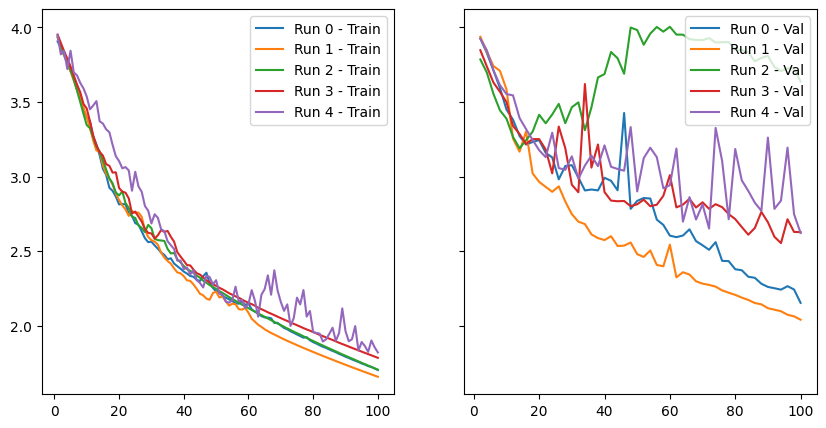

0.0 0.1 176
0.1 0.2 20
0.2 0.30000000000000004 6
0.30000000000000004 0.4 9
0.4 0.5 9
0.5 0.6000000000000001 6
0.6000000000000001 0.7000000000000001 7
0.7000000000000001 0.8 6
0.8 0.9 17
0.9 1.0 119


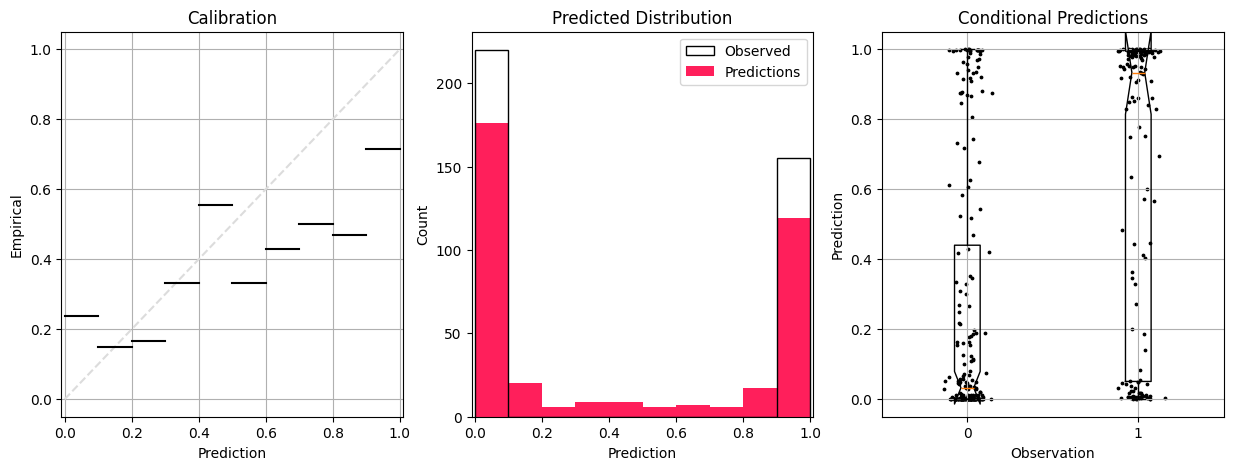

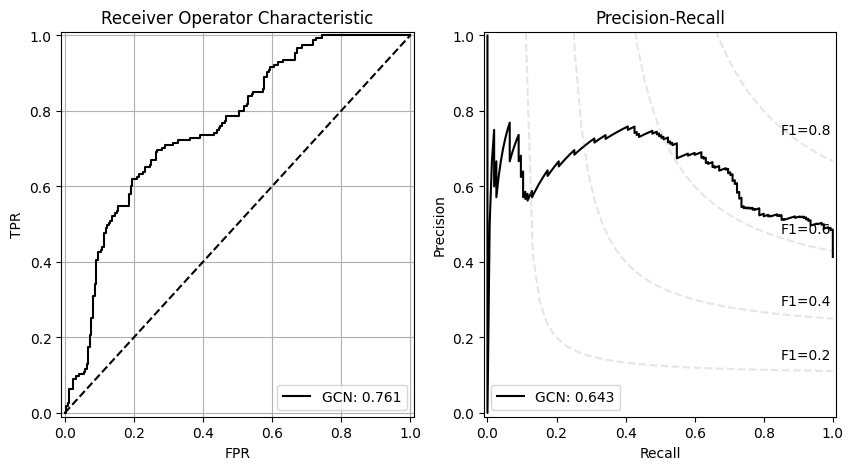

0.0 0.1 556
0.1 0.2 28
0.2 0.30000000000000004 24
0.30000000000000004 0.4 18
0.4 0.5 15
0.5 0.6000000000000001 10
0.6000000000000001 0.7000000000000001 7
0.7000000000000001 0.8 9
0.8 0.9 11
0.9 1.0 48


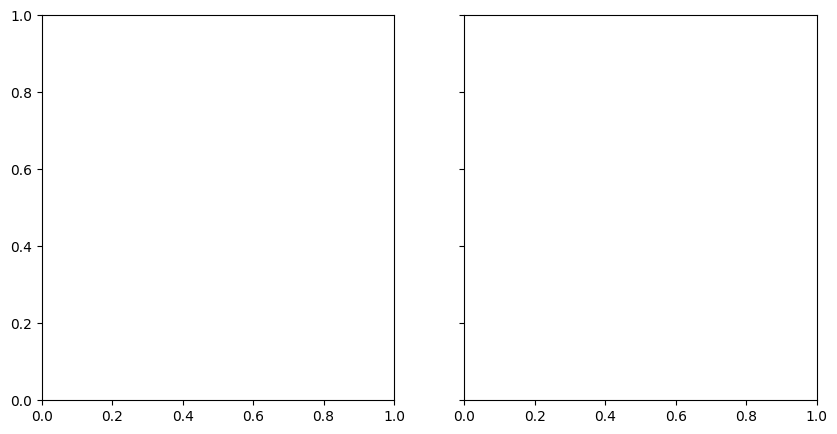

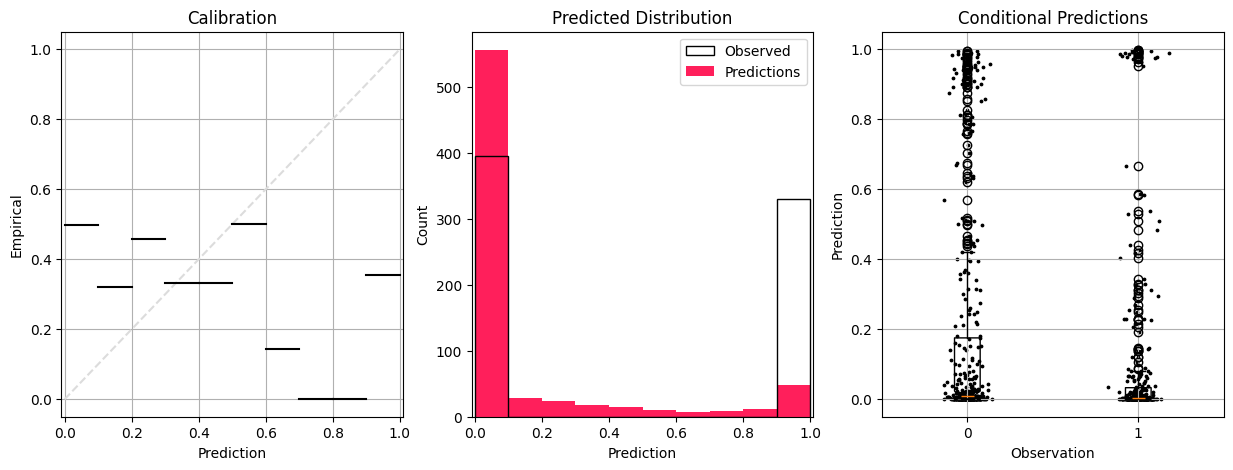

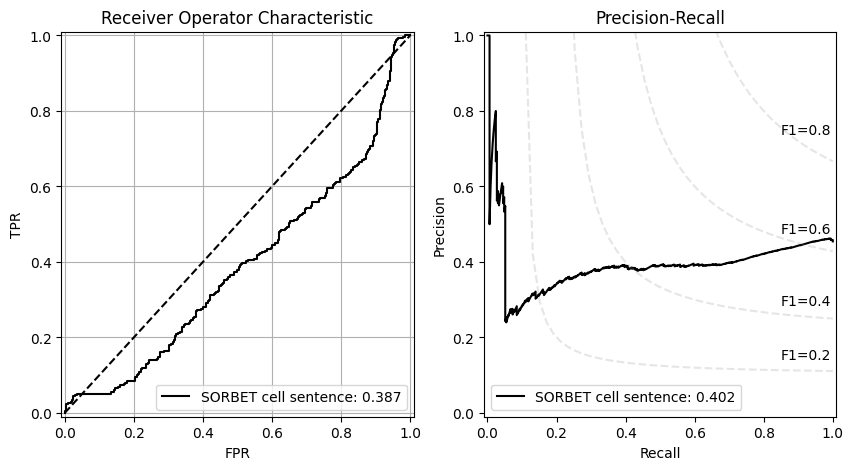

In [9]:
train_model_on_one_chort_and_test_on_the_other(1, "data/c{cnum}/cell_sentence_subgraphs", "SORBET cell sentence", 768)

(objective pid=1570004) Training on 413 samples, validating on 149 samples.
(objective pid=1570004) /home/shay/SORBET_shay
(objective pid=1570143) Training on 413 samples, validating on 149 samples.
(objective pid=1570143) /home/shay/SORBET_shay
(objective pid=1570276) Training on 413 samples, validating on 149 samples.
(objective pid=1570276) /home/shay/SORBET_shay
(objective pid=1570412) Training on 413 samples, validating on 149 samples.
(objective pid=1570412) /home/shay/SORBET_shay
(objective pid=1570552) Training on 413 samples, validating on 149 samples.
(objective pid=1570552) /home/shay/SORBET_shay
(objective pid=1570689) Training on 413 samples, validating on 149 samples.
(objective pid=1570689) /home/shay/SORBET_shay
(objective pid=1570877) Training on 413 samples, validating on 149 samples.
(objective pid=1570877) /home/shay/SORBET_shay
(objective pid=1570962) Training on 413 samples, validating on 149 samples.
(objective pid=1570962) /home/shay/SORBET_shay
(objective pid=1

2023-12-18 19:49:19,233	INFO tune.py:1148 -- Total run time: 2959.99 seconds (2959.95 seconds for the tuning loop).


{'epochs': 100, 'learning_rate': 0.0004352578494445275, 'batch_size': 64, 'restarts': 1}


  0%|          | 0/5 [00:00<?, ?it/s]

Split 0 AUROC: 0.743
Split 1 AUROC: 0.673
Split 2 AUROC: 0.623
Split 3 AUROC: 0.295
Split 4 AUROC: 0.794


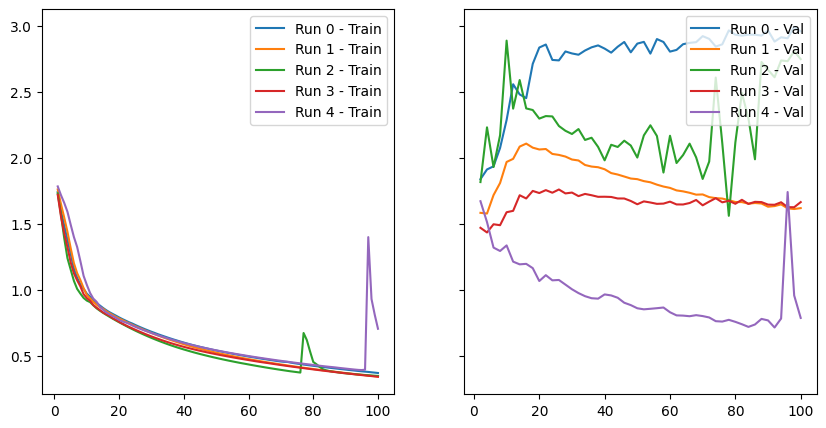

0.0 0.1 349
0.1 0.2 31
0.2 0.30000000000000004 17
0.30000000000000004 0.4 16
0.4 0.5 19
0.5 0.6000000000000001 8
0.6000000000000001 0.7000000000000001 7
0.7000000000000001 0.8 17
0.8 0.9 33
0.9 1.0 229


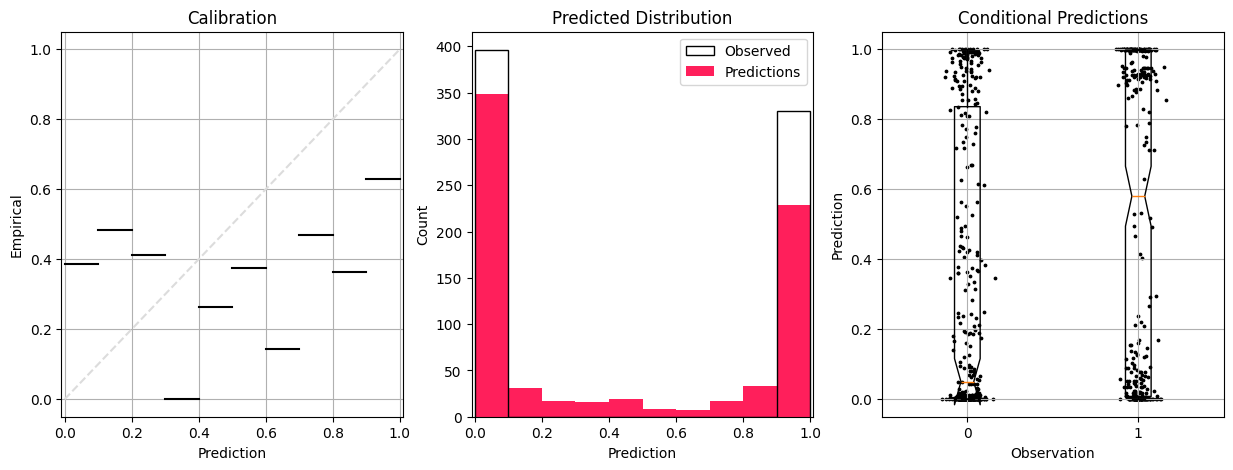

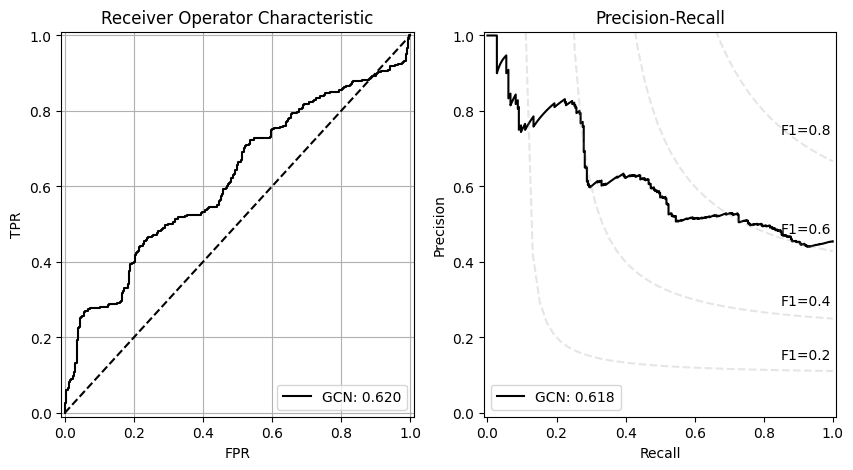

0.0 0.1 0
0.1 0.2 0
0.2 0.30000000000000004 0
0.30000000000000004 0.4 0
0.4 0.5 0
0.5 0.6000000000000001 0
0.6000000000000001 0.7000000000000001 0
0.7000000000000001 0.8 0
0.8 0.9 0
0.9 1.0 375


/usr/local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


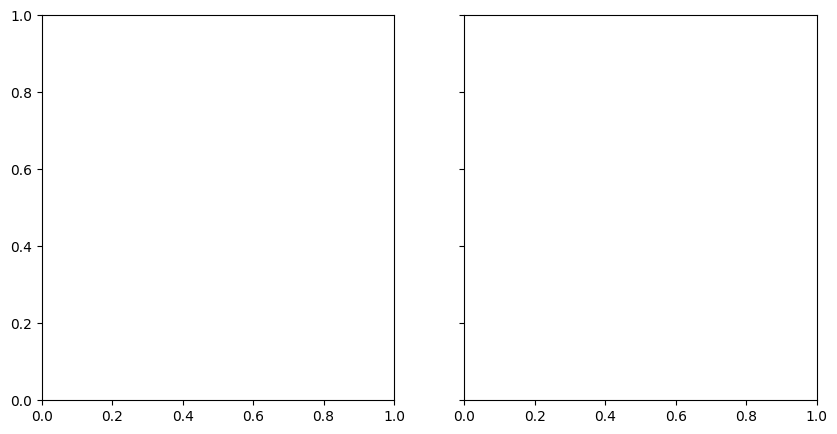

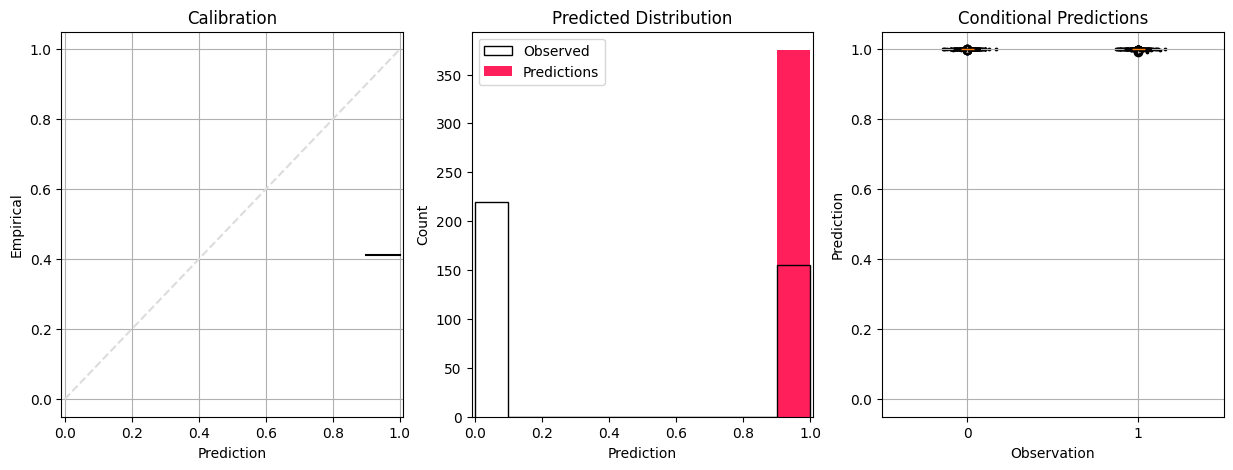

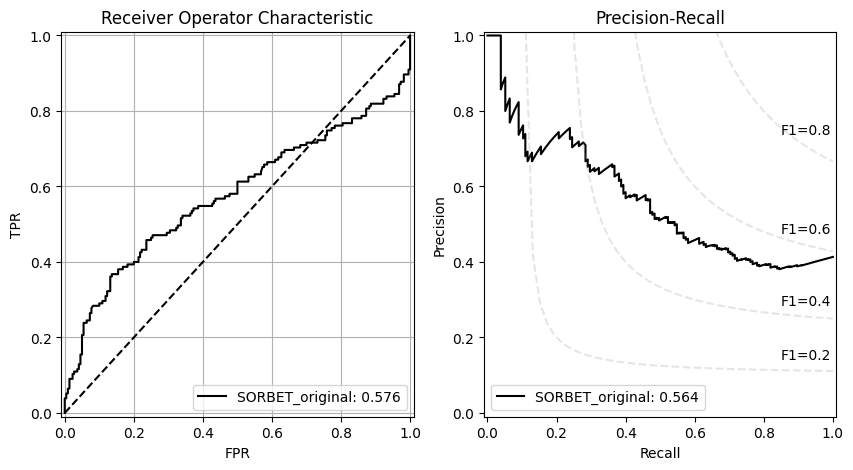

In [12]:
train_model_on_one_chort_and_test_on_the_other(2, "data/c{cnum}/original_subgraphs", "SORBET_original", 29)

(objective pid=1603390) Training on 449 samples, validating on 110 samples.
(objective pid=1603390) /home/shay/SORBET_shay
(objective pid=1603516) Training on 449 samples, validating on 110 samples.
(objective pid=1603516) /home/shay/SORBET_shay
(objective pid=1603643) Training on 449 samples, validating on 110 samples.
(objective pid=1603643) /home/shay/SORBET_shay
(objective pid=1603794) Training on 449 samples, validating on 110 samples.
(objective pid=1603794) /home/shay/SORBET_shay
(objective pid=1603909) Training on 449 samples, validating on 110 samples.
(objective pid=1603909) /home/shay/SORBET_shay
(objective pid=1604033) Training on 449 samples, validating on 110 samples.
(objective pid=1604033) /home/shay/SORBET_shay
(objective pid=1604167) Training on 449 samples, validating on 110 samples.
(objective pid=1604167) /home/shay/SORBET_shay
(objective pid=1604298) Training on 449 samples, validating on 110 samples.
(objective pid=1604298) /home/shay/SORBET_shay
(objective pid=1

2023-12-18 20:55:48,182	INFO tune.py:1148 -- Total run time: 3385.39 seconds (3385.34 seconds for the tuning loop).


{'epochs': 100, 'learning_rate': 0.00018881247382373226, 'batch_size': 64, 'restarts': 1}


  0%|          | 0/5 [00:00<?, ?it/s]

Split 0 AUROC: 0.613
Split 1 AUROC: 0.832
Split 2 AUROC: 0.361
Split 3 AUROC: 0.600
Split 4 AUROC: 0.926


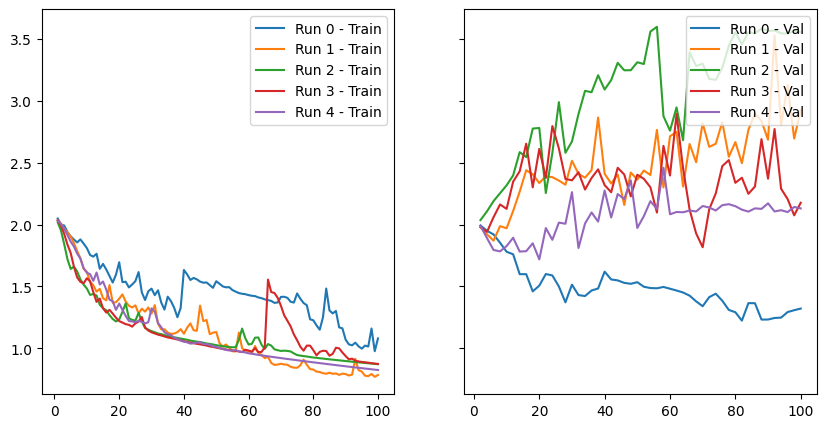

0.0 0.1 268
0.1 0.2 45
0.2 0.30000000000000004 20
0.30000000000000004 0.4 21
0.4 0.5 23
0.5 0.6000000000000001 29
0.6000000000000001 0.7000000000000001 16
0.7000000000000001 0.8 111
0.8 0.9 18
0.9 1.0 175


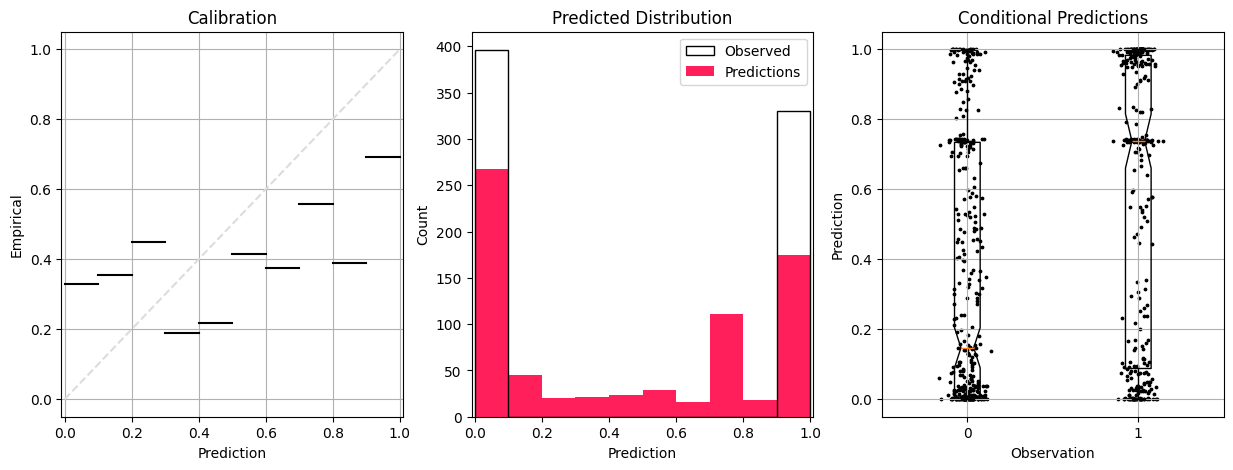

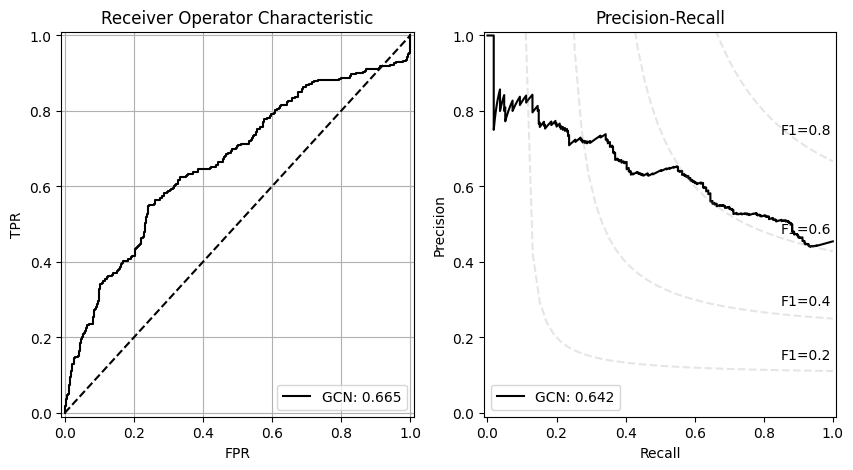

0.0 0.1 0
0.1 0.2 0
0.2 0.30000000000000004 0
0.30000000000000004 0.4 0
0.4 0.5 0
0.5 0.6000000000000001 0
0.6000000000000001 0.7000000000000001 0
0.7000000000000001 0.8 1
0.8 0.9 2
0.9 1.0 372


/usr/local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


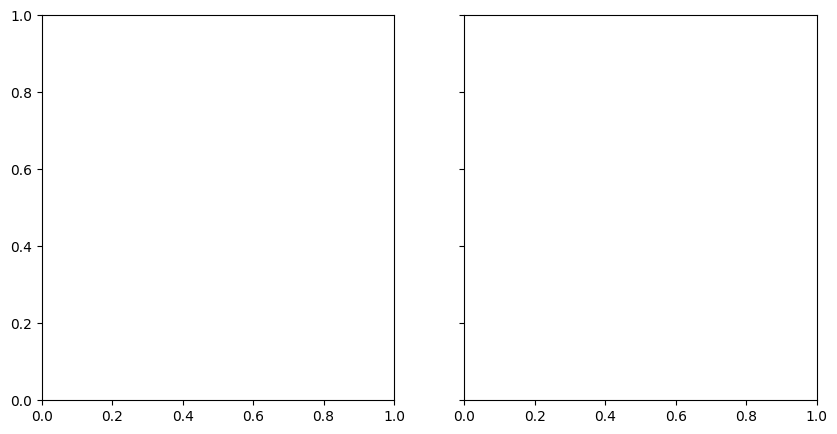

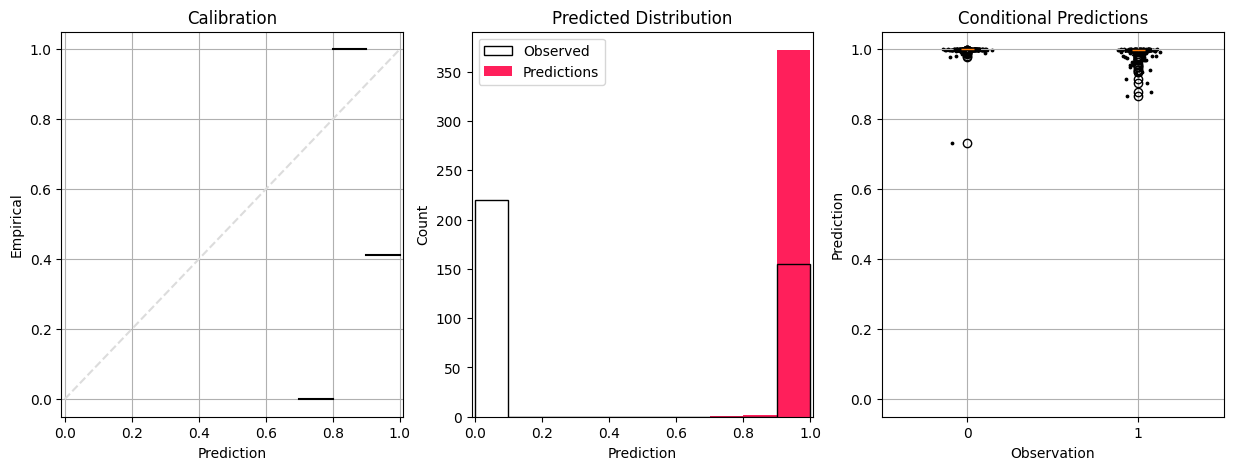

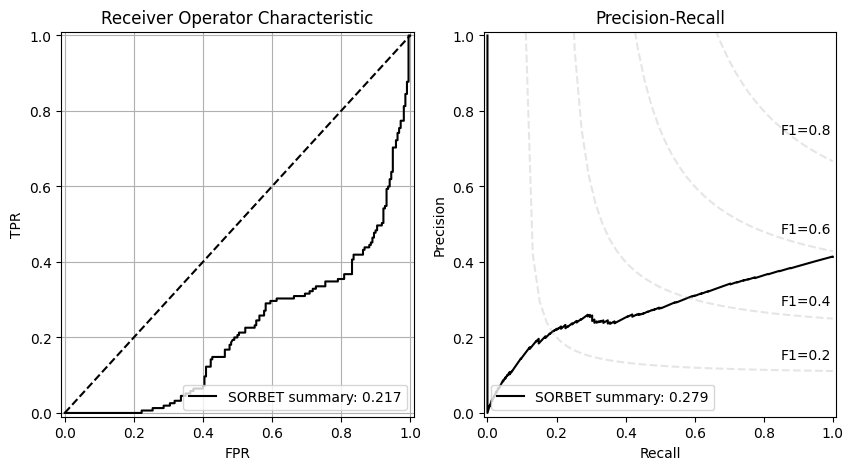

In [13]:
train_model_on_one_chort_and_test_on_the_other(2, "data/c{cnum}/summary_subgraphs", "SORBET summary", 768)

(objective pid=1640905) Training on 428 samples, validating on 123 samples.
(objective pid=1640905) /home/shay/SORBET_shay
(objective pid=1641049) Training on 428 samples, validating on 123 samples.
(objective pid=1641049) /home/shay/SORBET_shay
(objective pid=1641189) Training on 428 samples, validating on 123 samples.
(objective pid=1641189) /home/shay/SORBET_shay
(objective pid=1641319) Training on 428 samples, validating on 123 samples.
(objective pid=1641319) /home/shay/SORBET_shay
(objective pid=1641456) Training on 428 samples, validating on 123 samples.
(objective pid=1641456) /home/shay/SORBET_shay
(objective pid=1641596) Training on 428 samples, validating on 123 samples.
(objective pid=1641596) /home/shay/SORBET_shay
(objective pid=1641729) Training on 428 samples, validating on 123 samples.
(objective pid=1641729) /home/shay/SORBET_shay
(objective pid=1641869) Training on 428 samples, validating on 123 samples.
(objective pid=1641869) /home/shay/SORBET_shay
(objective pid=1

2023-12-18 22:04:20,518	INFO tune.py:1148 -- Total run time: 3427.76 seconds (3427.71 seconds for the tuning loop).


{'epochs': 100, 'learning_rate': 0.0001006171560949764, 'batch_size': 64, 'restarts': 1}


  0%|          | 0/5 [00:00<?, ?it/s]

Split 0 AUROC: 0.693
Split 1 AUROC: 0.632
Split 2 AUROC: 0.785
Split 3 AUROC: 0.996
Split 4 AUROC: 0.533


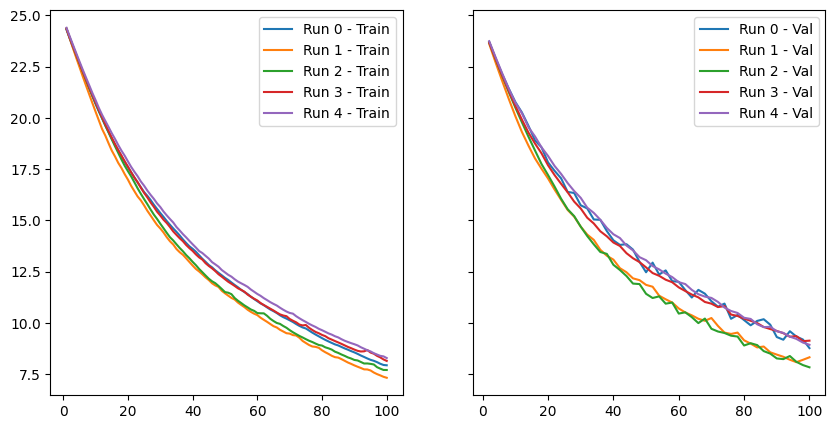

0.0 0.1 177
0.1 0.2 81
0.2 0.30000000000000004 40
0.30000000000000004 0.4 37
0.4 0.5 26
0.5 0.6000000000000001 34
0.6000000000000001 0.7000000000000001 55
0.7000000000000001 0.8 42
0.8 0.9 34
0.9 1.0 200


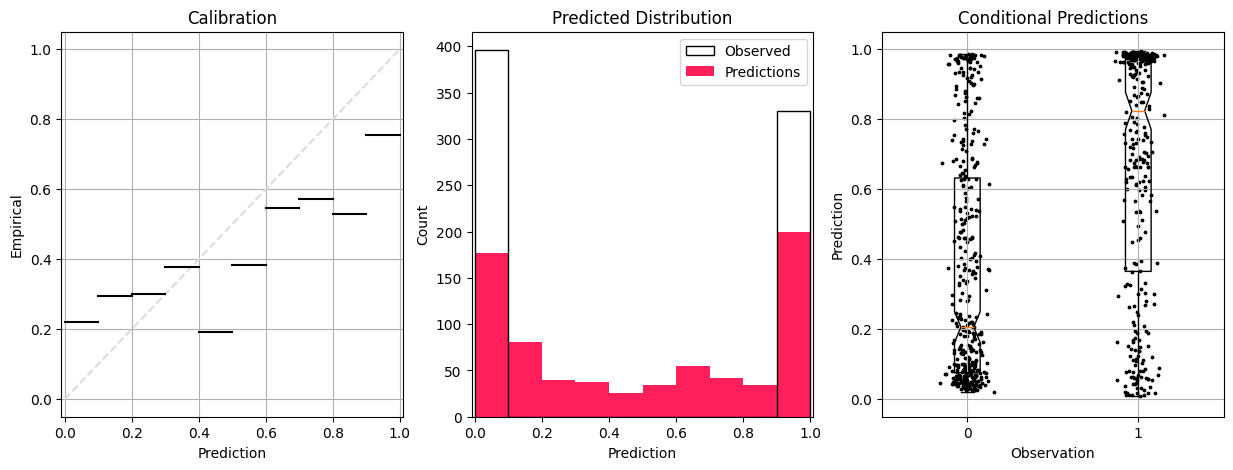

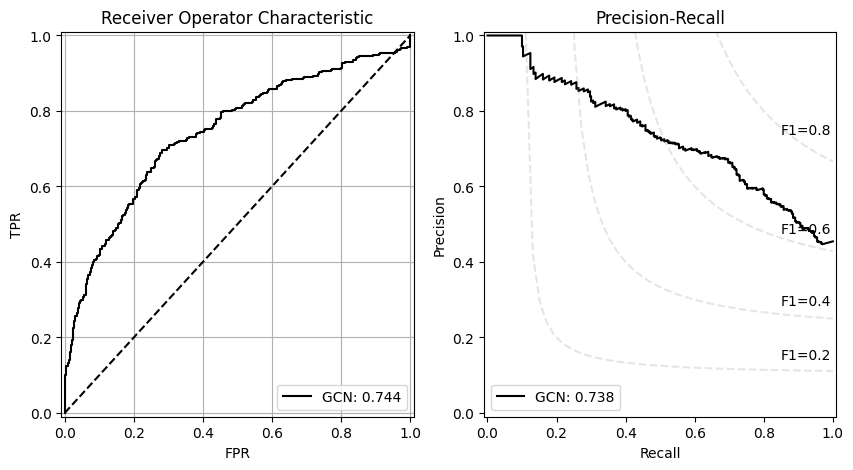

0.0 0.1 38
0.1 0.2 22
0.2 0.30000000000000004 16
0.30000000000000004 0.4 23
0.4 0.5 18
0.5 0.6000000000000001 12
0.6000000000000001 0.7000000000000001 20
0.7000000000000001 0.8 28
0.8 0.9 51
0.9 1.0 147


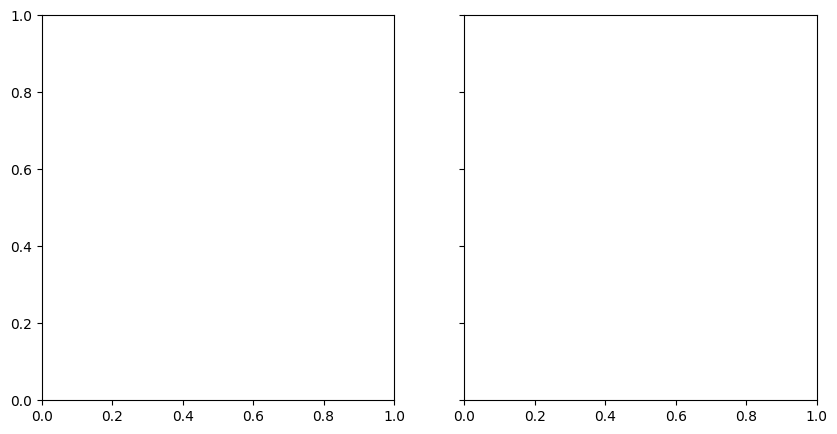

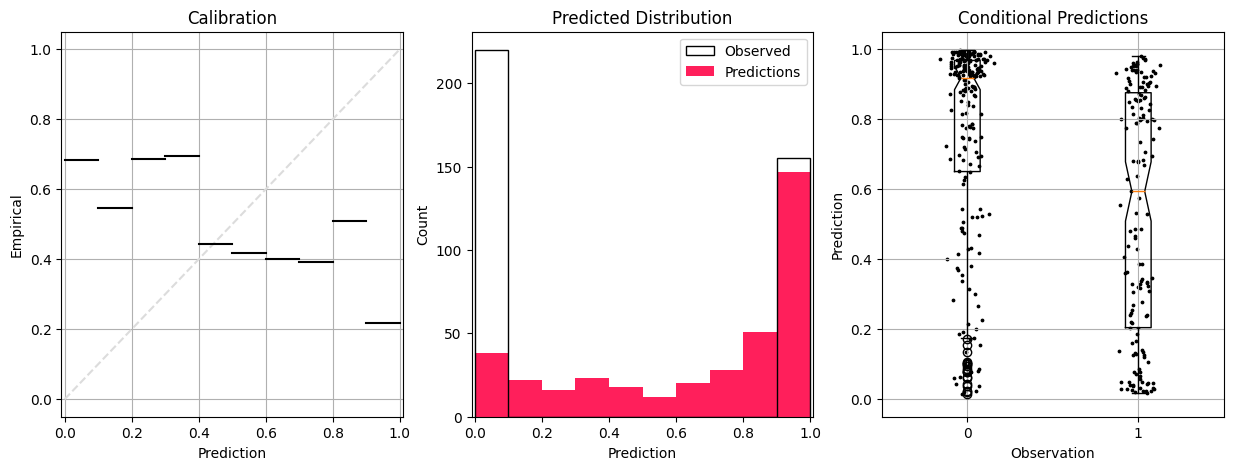

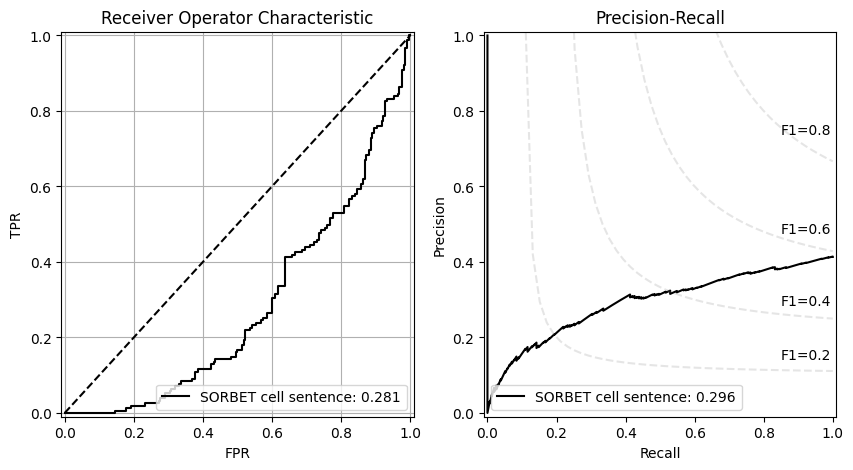

In [14]:
train_model_on_one_chort_and_test_on_the_other(2, "data/c{cnum}/cell_sentence_subgraphs", "SORBET cell sentence", 768)